In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-19T22:25:37.612100+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score
from sklearn import preprocessing
from catboost import CatBoostRegressor, Pool, cv

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from catboost import __version__ as cb_version
from sklearn import __version__ as sklearn_version

print(f'cb_version: {cb_version}')
print(f'sklearn_version: {sklearn_version}')

cb_version: 0.24.3
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

seaborn   : 0.11.1
numpy     : 1.20.3
matplotlib: 3.3.4
pandas    : 0.25.3
sklearn   : 0.24.2



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487
XGB_RANDOMSEED = 56

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [8]:
NTRY = 20
NAME = f'{NTRY}_cb_pca64_sber_lags_parse_bord_nose_full'

In [9]:
#CTR_UKR = 1.39808553
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [10]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'), index_col= 0)
x_train  = pd.read_csv(os.path.join(DIR_DATA, 'x_train.csv'), index_col= 0)
x_val    = pd.read_csv(os.path.join(DIR_DATA, 'x_val.csv'), index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'), index_col= 0)

#with open(os.path.join(DIR_DATA, 'cat_columns.pkl'), 'rb') as pickle_file:
#    cat_cols = pkl.load(pickle_file)
    
#with open(os.path.join(DIR_DATA, 'num_columns.pkl'), 'rb') as pickle_file:
#    num_cols = pkl.load(pickle_file)
    
with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)


In [11]:
x_train.shape, x_val.shape, df_test.shape, #len(cat_cols), len(num_cols)

((5584, 292), (1397, 292), (3000, 289))

отделяем метки от данных

In [12]:
y_train = x_train[['views', 'depth', 'full_reads_percent']]
y_val   = x_val[['views', 'depth', 'full_reads_percent']]

x_train.drop(['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)
x_val.drop(  ['views', 'depth', 'full_reads_percent'], axis = 1, inplace = True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5584, 289), (1397, 289), (5584, 3), (1397, 3))

In [13]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [14]:
num_cols.extend(['hour', 'mounth'])
cat_cols.extend(['dow', 
                 'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr',
                 #'spec_event_1',
                ])

In [15]:
for el in cat_cols:
    df_train[el] = df_train[el].astype(str)
    x_train[el] = x_train[el].astype(str)
    x_val[el]   = x_val[el].astype(str)
    df_test[el] = df_test[el].astype(str)

In [16]:
#views
train_ds_views = Pool(x_train[cat_cols + num_cols],
#train_ds_views = Pool(x_train[cat_cols + ['ctr']],
                      y_train[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )

val_ds_views   = Pool(x_val[cat_cols + num_cols],
#val_ds_views   = Pool(x_val[cat_cols + ['ctr']],
                      y_val[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )
train_views_full = Pool(df_train[cat_cols + num_cols],
#train_ds_views = Pool(x_train[cat_cols + ['ctr']],
                      df_train[['views']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )



#depth
train_ds_depth = Pool(x_train[cat_cols + num_cols],
                      y_train[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )

val_ds_depth   = Pool(x_val[cat_cols + num_cols],
                      y_val[['depth']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols
                     )
train_depth_full = Pool(df_train[cat_cols + num_cols],
#train_ds_views = Pool(x_train[cat_cols + ['ctr']],
                      df_train[['depth']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )


#full_reads_percent
#у frp корреляция с depth. так что добавим признак deprh_pred и соберем датасет уже после предсказания depth

In [17]:
def plot_feature_importance2(inp_model, inp_pool, imp_number = 30):
    
    data = pd.DataFrame({'feature_importance': inp_model.get_feature_importance(inp_pool), 
              'feature_names': inp_pool.get_feature_names()}).sort_values(by=['feature_importance'], 
                                                       ascending=True)
    
    data.nlargest(imp_number, columns="feature_importance").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [18]:
def plot_feature_importance(importance,names,model_type, imp_number = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

## views

In [53]:
cb_params_views = {"iterations": 500,
                  #"depth": 2,
                  "loss_function": "RMSE",
                  'eval_metric': 'R2',
                  "verbose": False
                  }

In [54]:
%%time
scores_views = cv(train_views_full,
                  cb_params_views,
                  fold_count=5,
                  seed = CB_RANDOMSEED, 
                  #plot="True"
                 )

Wall time: 11min 57s


In [55]:
#scores_views

In [57]:
scores_views[scores_views['test-R2-mean'] == scores_views['test-R2-mean'].max()]

,iterations,test-R2-mean,test-R2-std,train-R2-mean,train-R2-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
499,499,0.586063,0.094889,0.889387,0.010861,38385.49886,13938.482288,20017.628044,948.534498


In [ ]:
views_iter = scores_views['test-R2-mean'].argmax()
print(views_iter)

In [52]:
cb_model_views = CatBoostRegressor(iterations=views_iter,
                                 #learning_rate=0.05,
                                 #depth=10,
                                 random_seed = CB_RANDOMSEED,
                                 #n_estimators=100,
                                  )
# Fit model
cb_model_views.fit(train_views_full#train_ds_views,
                  #train_data, train_labels,
                  #eval_set=val_ds_views, 
                  #plot = True,
                  )

Learning rate set to 0.055159
0:	learn: 59155.1099169	total: 63.4ms	remaining: 1m 3s
1:	learn: 57904.5999762	total: 105ms	remaining: 52.2s
2:	learn: 56802.6082088	total: 149ms	remaining: 49.4s
3:	learn: 55790.3313398	total: 202ms	remaining: 50.3s
4:	learn: 54726.2019375	total: 250ms	remaining: 49.8s
5:	learn: 53803.2308992	total: 293ms	remaining: 48.5s
6:	learn: 52866.5130634	total: 332ms	remaining: 47.2s
7:	learn: 51978.4084315	total: 376ms	remaining: 46.6s
8:	learn: 51078.9042573	total: 427ms	remaining: 47s
9:	learn: 50253.5747065	total: 469ms	remaining: 46.5s
10:	learn: 49531.0638869	total: 512ms	remaining: 46s
11:	learn: 48856.0000155	total: 553ms	remaining: 45.5s
12:	learn: 48150.0851293	total: 606ms	remaining: 46s
13:	learn: 47466.5983497	total: 649ms	remaining: 45.7s
14:	learn: 46931.7800992	total: 697ms	remaining: 45.7s
15:	learn: 46356.7589650	total: 742ms	remaining: 45.7s
16:	learn: 45846.3905422	total: 787ms	remaining: 45.5s
17:	learn: 45346.5936366	total: 833ms	remaining: 4

In [24]:
# Get predictions and metrics
preds_train_views = cb_model_views.predict(x_train[cat_cols + num_cols])
preds_val_views   = cb_model_views.predict(val_ds_views)

train_score_views = r2_score(y_train["views"], preds_train_views)
val_score_views   = r2_score(y_val["views"],   preds_val_views)

train_score_views, val_score_views

(0.943651830026034, 0.9289773694791487)

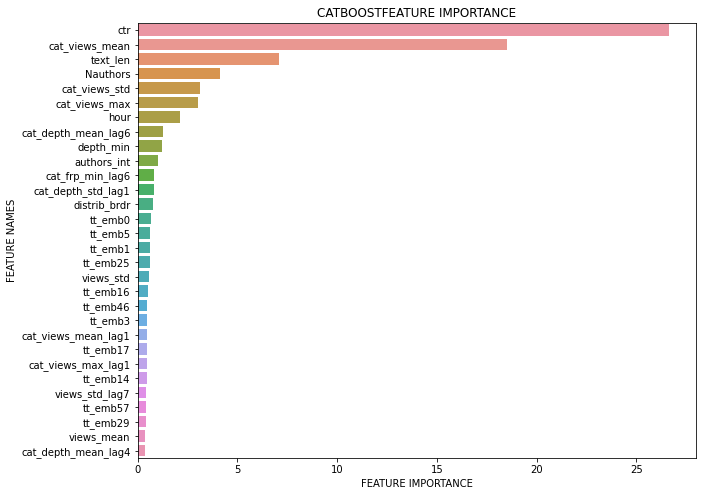

In [25]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_views.get_feature_importance(), train_ds_views.get_feature_names(), 'CATBOOST')

## depth

In [26]:
cb_params_depth = cb_params_views

In [27]:
%%time
scores_depth = cv(train_depth_full,
                  cb_params_depth,
                  fold_count=5,
                  seed = CB_RANDOMSEED, 
                  #plot="True"
                 )

Wall time: 2min 11s


In [28]:
scores_depth[scores_depth['test-R2-mean'] == scores_depth['test-R2-mean'].max()]

,iterations,test-R2-mean,test-R2-std,train-R2-mean,train-R2-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
99,99,-0.265,0.019129,-0.192406,0.013376,0.069446,0.002758,0.067472,0.000254


In [29]:
cb_model_depth = CatBoostRegressor(#iterations=1000,
                                 #learning_rate=0.05,
                                 #depth=10,
                                 random_seed = CB_RANDOMSEED,
                                 n_estimators=100,
                                  )
# Fit model
cb_model_depth.fit(train_depth_full#train_ds_depth,
                   #eval_set=val_ds_depth, 
                   #plot = True,
                  )

Learning rate set to 0.317408
0:	learn: 0.0484910	total: 44.7ms	remaining: 4.43s
1:	learn: 0.0399699	total: 100ms	remaining: 4.9s
2:	learn: 0.0348193	total: 143ms	remaining: 4.63s
3:	learn: 0.0318671	total: 187ms	remaining: 4.49s
4:	learn: 0.0297785	total: 229ms	remaining: 4.36s
5:	learn: 0.0283132	total: 271ms	remaining: 4.24s
6:	learn: 0.0275049	total: 312ms	remaining: 4.14s
7:	learn: 0.0267105	total: 353ms	remaining: 4.06s
8:	learn: 0.0263227	total: 393ms	remaining: 3.98s
9:	learn: 0.0260844	total: 436ms	remaining: 3.93s
10:	learn: 0.0257951	total: 487ms	remaining: 3.94s
11:	learn: 0.0255858	total: 530ms	remaining: 3.89s
12:	learn: 0.0254469	total: 572ms	remaining: 3.83s
13:	learn: 0.0253151	total: 615ms	remaining: 3.77s
14:	learn: 0.0250674	total: 662ms	remaining: 3.75s
15:	learn: 0.0248584	total: 720ms	remaining: 3.78s
16:	learn: 0.0247943	total: 770ms	remaining: 3.76s
17:	learn: 0.0246513	total: 814ms	remaining: 3.71s
18:	learn: 0.0245437	total: 861ms	remaining: 3.67s
19:	learn: 

In [30]:
# Get predictions and metrics
preds_train_depth = cb_model_depth.predict(x_train[cat_cols + num_cols])
preds_val_depth   = cb_model_depth.predict(val_ds_depth)

train_score_depth = r2_score(y_train["depth"], preds_train_depth)
val_score_depth   = r2_score(y_val["depth"],   preds_val_depth)

train_score_depth, val_score_depth

(0.9398989373599567, 0.9359906060340354)

In [31]:
x_train.shape

(5584, 289)

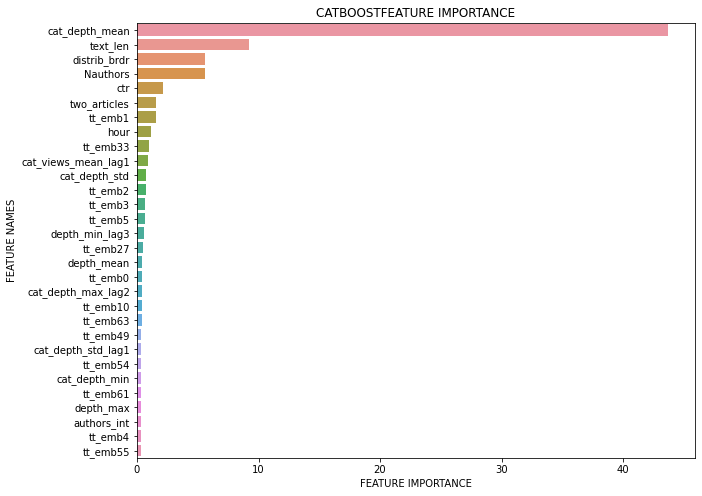

In [32]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_depth.get_feature_importance(), train_ds_depth.get_feature_names(), 'CATBOOST')

## full_reads_percent

In [33]:
#pd.DataFrame(preds_train_depth, columns = ['depth_pred'])
pred_scaler = preprocessing.StandardScaler()
tmp = pred_scaler.fit_transform(preds_train_depth.reshape(-1, 1))
pred_depth_train = pd.DataFrame(tmp, columns = ['depth_pred'])

pred_depth_val   = pd.DataFrame(pred_scaler.transform(preds_val_depth.reshape(-1, 1)), columns = ['depth_pred'])

In [34]:
#train_ds_frp = Pool(x_train[cat_cols + num_cols + ['depth_pred']],
train_ds_frp = Pool(x_train[cat_cols + num_cols],
                      y_train[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols,
                     )

#val_ds_frp   = Pool(x_val[cat_cols + num_cols + ['depth_pred']],
val_ds_frp   = Pool(x_val[cat_cols + num_cols],
                      y_val[['full_reads_percent']],
                      cat_features = cat_cols,
                      feature_names = cat_cols + num_cols,
                     )
train_frp_full = Pool(df_train[cat_cols + num_cols],
                      df_train[['full_reads_percent']],
                      cat_features = cat_cols,
                      #feature_names = cat_cols + num_cols
                     )

In [35]:
cb_params_frp = cb_params_views

In [36]:
%%time
scores_frp = cv(train_frp_full,
                  cb_params_frp,
                  fold_count=5,
                  seed = CB_RANDOMSEED, 
                  #plot="True"
                 )

Wall time: 2min 12s


In [37]:
scores_frp[scores_frp['test-R2-mean'] == scores_frp['test-R2-mean'].max()]

,iterations,test-R2-mean,test-R2-std,train-R2-mean,train-R2-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
99,99,0.439756,0.016117,0.469026,0.004297,7.586034,0.232034,7.390794,0.029972


In [38]:
cb_model_frp = CatBoostRegressor(#iterations=1000,
                                 #learning_rate=0.05,
                                 #depth=10,
                                 random_seed = CB_RANDOMSEED,
                                 n_estimators=100,
                                 #n_estimators=100,
    #num_trees=None,
                                )
# Fit model
cb_model_frp.fit(train_frp_full#train_ds_frp,
                   #eval_set=val_ds_frp, 
                   #plot = True,
                  )

Learning rate set to 0.317408
0:	learn: 8.8655509	total: 43.7ms	remaining: 4.33s
1:	learn: 8.1488371	total: 88.1ms	remaining: 4.32s
2:	learn: 7.7145340	total: 139ms	remaining: 4.5s
3:	learn: 7.4171257	total: 195ms	remaining: 4.67s
4:	learn: 7.2183612	total: 245ms	remaining: 4.65s
5:	learn: 7.0793368	total: 286ms	remaining: 4.47s
6:	learn: 6.9636283	total: 330ms	remaining: 4.39s
7:	learn: 6.9012326	total: 374ms	remaining: 4.3s
8:	learn: 6.8408032	total: 427ms	remaining: 4.32s
9:	learn: 6.7797325	total: 475ms	remaining: 4.28s
10:	learn: 6.7508749	total: 522ms	remaining: 4.22s
11:	learn: 6.7142549	total: 566ms	remaining: 4.15s
12:	learn: 6.6677584	total: 612ms	remaining: 4.1s
13:	learn: 6.6377402	total: 653ms	remaining: 4.01s
14:	learn: 6.6047247	total: 709ms	remaining: 4.02s
15:	learn: 6.5808320	total: 752ms	remaining: 3.95s
16:	learn: 6.5410205	total: 797ms	remaining: 3.89s
17:	learn: 6.5065698	total: 840ms	remaining: 3.83s
18:	learn: 6.4764817	total: 881ms	remaining: 3.76s
19:	learn: 6

In [39]:
# Get predictions and metrics
preds_train_frp = cb_model_frp.predict(x_train[cat_cols + num_cols])
preds_val_frp   = cb_model_frp.predict(val_ds_frp)

train_score_frp = r2_score(y_train["full_reads_percent"], preds_train_frp)
val_score_frp   = r2_score(y_val["full_reads_percent"],   preds_val_frp)

train_score_frp, val_score_frp

(0.8020125218931917, 0.8086130516965471)

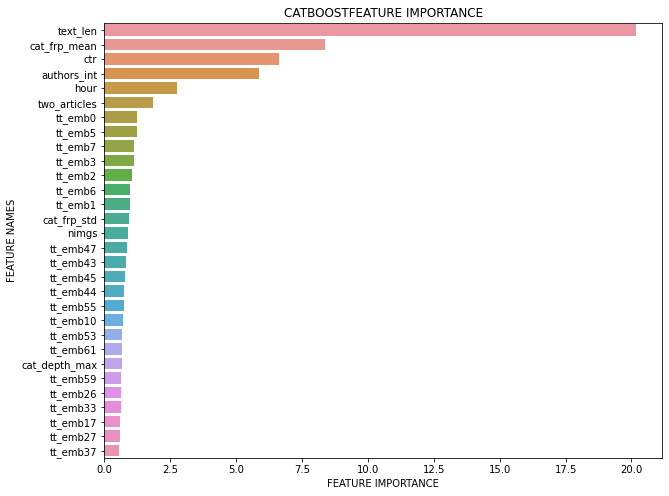

In [40]:
#plot_feature_importance(cb_model_views, train_ds_views, 30)
plot_feature_importance(cb_model_frp.get_feature_importance(), train_ds_frp.get_feature_names(), 'CATBOOST')

In [41]:
score_train = 0.4 * train_score_views + 0.3 * train_score_depth + 0.3 * train_score_frp
score_val  = 0.4 * val_score_views  + 0.3 * val_score_depth  + 0.3 * val_score_frp

score_train, score_val

(0.9000341697863581, 0.8949720451108342)

## Сохраняем предсказания для ансамблей / стекинга

In [42]:
x_train_pred = x_train[['document_id']]
x_val_pred   = x_val[['document_id']]

print('before ', x_train_pred.shape, preds_train_views.shape, preds_train_depth.shape, preds_train_frp.shape)
print('before ', x_val_pred.shape,   preds_val_views.shape,   preds_val_depth.shape,   preds_val_frp.shape)

# https://github.com/pandas-dev/pandas/issues/25349
x_train_pred = pd.concat([x_train_pred.reset_index(drop=True), 
                          pd.DataFrame(preds_train_views).reset_index(drop = True), 
                          pd.DataFrame(preds_train_depth).reset_index(drop = True), 
                          pd.DataFrame(preds_train_frp).reset_index(drop = True)
                         ], ignore_index = True, axis = 1)
x_val_pred   = pd.concat([x_val_pred.reset_index(drop=True),   
                          pd.DataFrame(preds_val_views).reset_index(drop = True), 
                          pd.DataFrame(preds_val_depth).reset_index(drop = True), 
                          pd.DataFrame(preds_val_frp).reset_index(drop = True)
                         ], ignore_index = True, axis = 1)

x_train_pred.columns = ['document_id', 'views_pred_cb', 'depth_pred_cb', 'frp_pred_cb']
x_val_pred.columns   = ['document_id', 'views_pred_cb', 'depth_pred_cb', 'frp_pred_cb']

print('after ', x_train_pred.shape)
print('after ', x_val_pred.shape)

x_train_pred.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_train_part.csv'), index = False)
x_val_pred.to_csv(os.path.join(DIR_SUBM_PART, f'{NAME}_val_part.csv'), index = False)

before  (5584, 1) (5584,) (5584,) (5584,)
before  (1397, 1) (1397,) (1397,) (1397,)
after  (5584, 4)
after  (1397, 4)


## save models

In [43]:
#cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NTRY}_pca64_cb_views.cbm'), 
cb_model_views.save_model(os.path.join(DIR_MODELS, f'{NAME}_v.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NAME}_d.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

cb_model_frp.save_model(os.path.join(DIR_MODELS, f'{NAME}_f.cbm'), 
                           format="cbm",
                           export_parameters=None,
                           pool=None
                         )

## make predict

In [44]:
pred_views = cb_model_views.predict(df_test[cat_cols + num_cols])
pred_depth = cb_model_depth.predict(df_test[cat_cols + num_cols])
pred_frp   = cb_model_frp.predict(  df_test[cat_cols + num_cols])

In [45]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [46]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,68961.348188,1.072315,15.248928
1440,117375.260520,1.179589,26.530941
2645,111037.800915,1.165289,26.974688


In [47]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [48]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,11700.741929,1.195904,40.990891
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,6324.398522,1.059544,26.132610
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,5649.704501,1.052508,28.305026
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,8020.319261,1.060021,35.588143
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,80519.669516,1.146678,23.767047


In [49]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)

In [50]:
df_train.columns

Index(['document_id', 'title', 'publish_date', 'session', 'authors', 'ctr',
       'category', 'tags', 'views', 'depth',
       ...
       'tt_emb54', 'tt_emb55', 'tt_emb56', 'tt_emb57', 'tt_emb58', 'tt_emb59',
       'tt_emb60', 'tt_emb61', 'tt_emb62', 'tt_emb63'],
      dtype='object', length=292)